# Обучение моделей, feature_importances, метрики качества
* # Регрессия
* # Кластеризация
## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')

In [3]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
df.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [8]:
df.columns = df.columns.str.replace(' ', '_')

In [15]:
df.shape

(8760, 14)

In [5]:
df.dtypes

Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['timestamp'] = df['date'].apply(lambda x: pd.Timestamp(x))
df['timestamp'] = df.timestamp.astype('int64') // 10**9
df = df.drop(['Date'], axis=1)

Так как модели машинного обучения умеют работать только с числами, преобразуем некоторые данные в понятный модели вид

In [11]:
cleanup_nums = {'Seasons':     {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3},
                'Holiday': {'No Holiday': 0, 'Holiday': 1},
                'Functioning_Day': {'Yes': 1, 'No': 0}}   

In [12]:
df = df.replace(cleanup_nums)

In [7]:
df.columns

Index(['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'date', 'timestamp'],
      dtype='object')

In [10]:
df = df.drop(['date'], axis=1)

In [13]:
df.head()

,Rented_Bike_Count,Hour,Temperature(°C),Humidity(%),Wind_speed_(m/s),Visibility_(10m),Dew_point_temperature(°C),Solar_Radiation_(MJ/m2),Rainfall(mm),Snowfall_(cm),Seasons,Holiday,Functioning_Day,timestamp
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1,1512086400
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1,1512086400
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1,1512086400
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1,1512086400
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1,1512086400


# Регрессия
## Попробуем предсказать на основе данных значения количества прокатов велосипедов("Rented_Bike_Count")

In [16]:
data_x = df.drop(['Rented_Bike_Count'], axis=1)
data_y = df.Rented_Bike_Count

## Random Forest model

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
%matplotlib inline

Разобьем датасет на тренировочную(80%) и тестовую часть(20%) 

In [175]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.20, random_state = 42)

In [321]:
# Метрики качества регрессии
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [155]:
reg_rf = RandomForestRegressor(n_estimators = 79, max_depth = 20, n_jobs=-1)

Путем подбора и тюнинга параметров с помощью GridSearchCV, были выявлены оптимальные параметры: (max_depth=20, n_estimators=79)

In [156]:
reg_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=79, n_jobs=-1)

## Посмотрим какие значения модель предсказывала

In [323]:
import warnings
warnings.filterwarnings('ignore')

# Make prediction
predictions = reg_rf.predict(X_test)

result = X_test[['Hour', 'Temperature(°C)']]
result['rented_bike_count'] = y_test
result['prediction'] = predictions.tolist()
result.head()

,Hour,Temperature(°C),rented_bike_count,prediction
6056,8,27.2,1728,1545.464838
5556,12,32.6,822,716.122540
5990,14,34.0,658,672.232989
7674,18,16.9,2716,2124.257444
3319,7,6.4,1083,620.405063


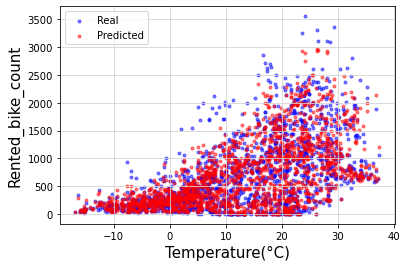

In [167]:
# Define x axis
x_axis = X_test['Temperature(°C)']

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Temperature(°C)', fontsize=15)
plt.ylabel('Rented_bike_count', fontsize=15)
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'upper left')
plt.show()

In [147]:
parametrs = {'n_estimators': range(75,80), 'max_depth': range(20,25)}

In [148]:
grid_reg_rf = GridSearchCV(reg_rf, param_grid=parametrs, cv=5, n_jobs=4)


In [149]:
grid_reg_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=30, n_estimators=85,
                                             n_jobs=-1),
             n_jobs=4,
             param_grid={'max_depth': range(20, 25),
                         'n_estimators': range(75, 80)})

In [150]:
grid_reg_rf.best_params_

{'max_depth': 20, 'n_estimators': 79}

Лучшие параметры

In [151]:
best_grid_reg_rf = grid_reg_rf.best_estimator_

## Посмотрим на метрики качества 

In [152]:
best_grid_reg_rf.score(X_test, y_test)

0.8746484613374145

In [158]:
mse = mean_squared_error(y_test, predictions)

mae = mean_absolute_error(y_test, predictions)

r2 = r2_score(y_test, predictions)

In [159]:
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 134.96
Mean Squared Error: 52509.31
R-squared scores: 0.87


Значения абсолютной и квадратичной ошибки велики, а вот r2_score неплохой

## Посмотрим, какие параметры сильно влияют на прокат велосипедов

In [160]:
feature_importances = best_grid_reg_rf.feature_importances_

In [161]:
feature_importances_df = pd.DataFrame({'features': list(X_train),
                                      'feature_importances': feature_importances})

Text(0.5, 1.0, 'Влияние параметров на прокат велосипедов')

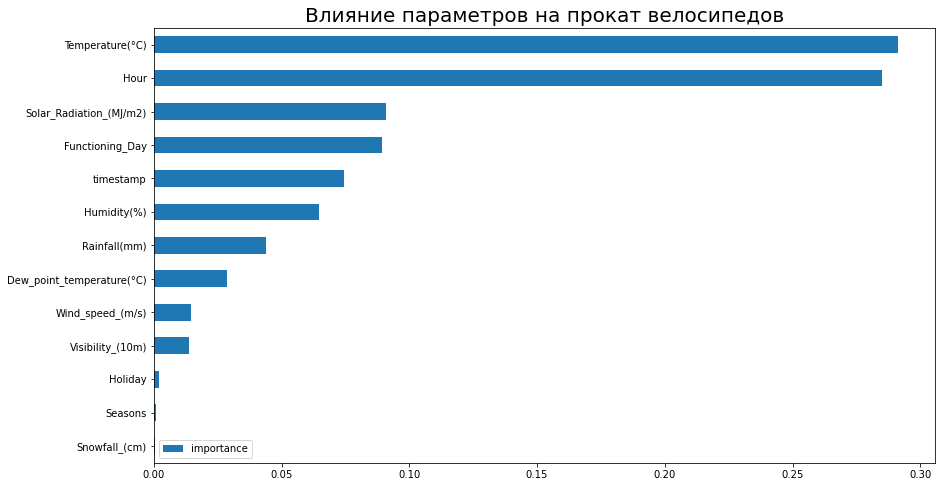

In [325]:
imp = pd.DataFrame(best_grid_reg_rf.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(14, 8))
plt.title('Влияние параметров на прокат велосипедов', fontsize = 20)

Видим, что температура, время дня влияют больше всего на прокат

# KNN model

Проделываем аналогичные операции, как с Random Forest

In [179]:
from sklearn import neighbors
from math import sqrt

In [193]:
params = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
model.best_params_


{'n_neighbors': 3}

In [327]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  
    pred = model.predict(X_test) #make prediction
    error = sqrt(mean_squared_error(y_test,pred))
    error2 = mean_squared_error(y_test,pred)
    rmse_val.append(error) #store rmse values
    print('RMSE value for k = ' , K , 'is:', error, 'MSE = ', error2)

RMSE value for k =  1 is: 487.22124216087434 MSE =  237384.53881278538
RMSE value for k =  2 is: 431.0240333473986 MSE =  185781.71732305936
RMSE value for k =  3 is: 422.01267921781533 MSE =  178094.7014205987
RMSE value for k =  4 is: 419.5212945926866 MSE =  175998.11661672374
RMSE value for k =  5 is: 421.8499070602695 MSE =  177957.344086758
RMSE value for k =  6 is: 424.24192837037873 MSE =  179981.21378741757
RMSE value for k =  7 is: 430.7988218899369 MSE =  185587.62494175756
RMSE value for k =  8 is: 439.6333234643547 MSE =  193277.45910031392
RMSE value for k =  9 is: 447.29986950060334 MSE =  200077.17325525678
RMSE value for k =  10 is: 453.8733245870366 MSE =  206000.99477168953
RMSE value for k =  11 is: 459.19025186518866 MSE =  210855.6874080154
RMSE value for k =  12 is: 465.17397436714595 MSE =  216386.82642852614
RMSE value for k =  13 is: 472.0494725132245 MSE =  222830.7045000135
RMSE value for k =  14 is: 478.3324201269809 MSE =  228801.90414453452
RMSE value for

Видно, что алгоритм KNN намного хуже предсказывает значение прокатов велосипедов

In [194]:
model.score(X_test, y_test)

0.572551759017139

<AxesSubplot:>

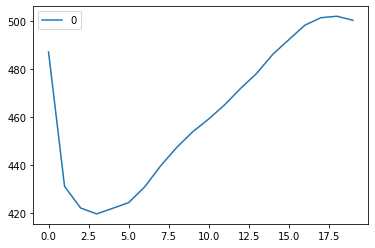

In [181]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

## Самым оптимальном значением параметра k оказалось k = 3

# Кластеризация

In [270]:
from sklearn.preprocessing import StandardScaler
X = df.values
X = np.nan_to_num(X)
Clust_dataset = StandardScaler().fit_transform(X)

In [271]:
Clust_dataset

array([[-0.69865046, -1.66132477, -1.51395724, ...,  0.18667989,
        -1.72731195,  0.00224005],
       [-0.77617457, -1.51686175, -1.53907415, ...,  0.18667989,
        -1.72731195,  0.00224005],
       [-0.82423951, -1.37239873, -1.58093567, ...,  0.18667989,
        -1.72731195,  0.00224005],
       ...,
       [-0.0164383 ,  1.37239873, -0.86091752, ...,  0.18667989,
         1.72731195,  1.22866919],
       [ 0.01147038,  1.51686175, -0.90277904, ...,  0.18667989,
         1.72731195,  1.22866919],
       [-0.18699134,  1.66132477, -0.91952365, ...,  0.18667989,
         1.72731195,  1.22866919]])

In [328]:
from sklearn.cluster import KMeans
ClusterNums = 2
k_means = KMeans(n_clusters=ClusterNums, n_init=12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 1 1 ... 0 0 0]


In [310]:
df['Clus_km'] = labels
df.head()

,Rented_Bike_Count,Hour,Temperature(°C),Humidity(%),Wind_speed_(m/s),Visibility_(10m),Dew_point_temperature(°C),Solar_Radiation_(MJ/m2),Rainfall(mm),Snowfall_(cm),Seasons,Holiday,Functioning_Day,timestamp,Clus_km
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1,1512086400,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1,1512086400,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1,1512086400,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1,1512086400,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1,1512086400,1


In [311]:
df.Clus_km.unique()

array([1, 0])

In [312]:
df.groupby('Clus_km').mean()

,Rented_Bike_Count,Hour,Temperature(°C),Humidity(%),Wind_speed_(m/s),Visibility_(10m),Dew_point_temperature(°C),Solar_Radiation_(MJ/m2),Rainfall(mm),Snowfall_(cm),Seasons,Holiday,Functioning_Day,timestamp
Clus_km,,,,,,,,,,,,,,
0,927.421676,11.5,20.385861,62.120674,1.552391,1531.087659,12.160633,0.64219,0.188479,0.028005,2.497268,0.038251,0.943761,1.535674e+09
1,480.558150,11.5,5.338759,54.310440,1.898375,1342.046016,-4.057440,0.49563,0.108677,0.122390,0.505495,0.060440,0.989011,1.519906e+09


In [313]:
df.describe()

,Rented_Bike_Count,Hour,Temperature(°C),Humidity(%),Wind_speed_(m/s),Visibility_(10m),Dew_point_temperature(°C),Solar_Radiation_(MJ/m2),Rainfall(mm),Snowfall_(cm),Seasons,Holiday,Functioning_Day,timestamp,Clus_km
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8.760000e+03,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,1.504110,0.049315,0.966324,1.527811e+09,0.498630
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,1.114408,0.216537,0.180404,9.104145e+06,0.500027
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.512086e+09,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.519949e+09,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,2.000000,0.000000,1.000000,1.527811e+09,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,2.000000,0.000000,1.000000,1.535674e+09,1.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,3.000000,1.000000,1.000000,1.543536e+09,1.000000


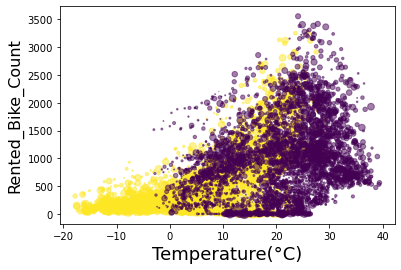

In [329]:
area = np.pi * (X[:, 4])**2
plt.scatter(X[:, 2], X[:, 0], s=area, c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Temperature(°C)', fontsize=18)
plt.ylabel('Rented_Bike_Count', fontsize=16)
plt.show()

# Наблюдаем 2 класса людей:
* ## Желтые берут велосипед в прокат в холодную погоду
* ## Фиолетые в большинстве своем берут в прокат в телпую и жаркую погоду

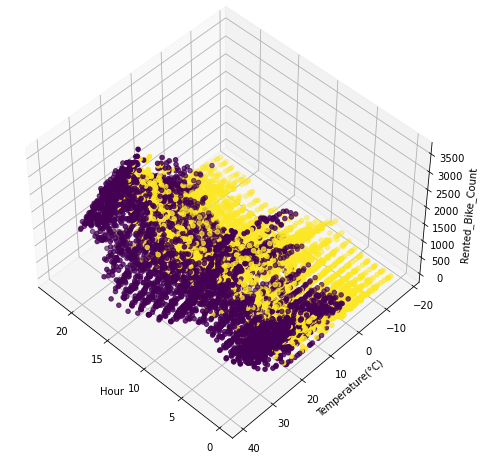

In [330]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.set_xlabel('Hour')
ax.set_ylabel('Temperature(°C)')
ax.set_zlabel('Rented_Bike_Count')

ax.scatter(X[:, 1], X[:, 2], X[:, 0], c=labels.astype(np.float))